# Battle of the Neighborhoods
## Optimization

__Table of Contents__

* [Calculating features](#Calculating-features)
* [Calculating targets](#Calculating-targets)
* [Gradient descent](#Gradient-descent)
* [Initialization](#Initialization)
* [Filtering](#Filtering)    
* [Final candidates](#Final-candidates)    
* [Summary](#Summary)

![](https://vignette.wikia.nocookie.net/phineasandferb/images/9/9b/Treehouse_Fight.jpg/revision/latest?cb=20090320212850)

__The story so far...__

In the notebook 'intro_data.ipynb', the [motivation](intro_data.ipynb#Introduction) for building a sports facility was outlined. [Data](intro_data.ipynb#Data) was also collected using Google Place API, and stored in JSON files. This data was collected for ten venue categories:
[Sports facilities, cinemas, pubs, gyms, banks, hospitals, supermarkets, schools, colleges, and restaurants](intro_data.ipynb#Points-of-interest-in-Hyderabad).

In 'preprocessing.ipynb', a large dataset of locations was built. The locations of existing sports facilities was supplemented with locations chosen randomly (uniformly) from the city. For all of these locations, the distances to ten nearest venues for each of the ten venue categories was calculated. This distance data was cast to a pandas DataFrame and subsequently stored to disk to the file 'fullDataset.json'.

In 'model_binary.ipynb', the dataset was used to train simple logistic regression models. Proximity to the closest sports venue was used as the suitability score, and then thresholded to obtain class labels - either suitable or unsuitable. The class imbalance in the data turned out to be a problem with binary classifiers. Trying to balance the data made things a bit too messy.

$~$

In 'model_continuous.ipynb', the suitability score (proximity to nearest sports venue) was used as the continuous target value. A simple linear regressions model was built, producing an $R^2$ of 0.5. A single layer perceptron pushed $R^2$ to 0.68 with 125 hidden units, and a multi layer perceptron with 3 hidden layers and (120,20,5) hidden units pushed $R^2$ further to 0.74. The errors were distributed a bit unevenly about zero, but they weren't too bad. There was some bias at the low and high ends of target values.  

$~$

In 'model_cluster.ipynb', we used K-Means clustering to see if the datapoints could be nicely separated without having to use suitability scores as labels. This did not go very well. The data was fairly continuous in terms of features, but suitability scores  didn't show clear separation in the space spanned by these features. 


__In this notebook...__

We use the MLP model with hidden layer sizes (100,20,5) to assign suitability scores to locations in the city. In the last few notebooks, this was straight-forward because of the preprocessing. Here, we do not restrict ourselves to just these 10,000+ points but search over the entire city. This means we'll have to extract features on-the-fly for any specified location. We'll go back to the nearest neighbors models for venue categories from the notebook 'preprocessing.ipynb'. 

We will use gradient descent (or some other algorithm depending on how it goes) to find ideal locations close to some initial location. Then, we filter out locations that are too close to existing sports facilities. This will produce a set of candidates that are ideal for setting up a sports facility, and is left to the business processes to handle from that point onwards.


In [1]:
import json
import numpy as np
import pandas as pd
import time # Will use sleep from time to pause 
import matplotlib.pyplot as plt
import folium

from warnings import warn
%matplotlib inline

In [2]:
venueCats = ["sports", "cinemas", "pubs", "gyms", "banks", 
             "hospitals", "supermarkets", "schools", "colleges", "restaurants"]
venueCats = sorted(venueCats, key=str.lower)

# Because we consider distances to other venues when defining features
# and distance to sports facilities when defining output labels and scores
venueCats_sans_sports = venueCats.copy()
venueCats_sans_sports.remove('sports')

# Location of the center of the city: 
# The location of the "Buddha Statue" in a lake called "Hussain Sagar" at the center of the city is used
latCC = lat_CC = 17.415435
lngCC = lng_CC = 78.474296

# Calculating features

In previous notebooks, we sometimes tried different ways of selecting features based on distances to nearest venues. For the MLP we are going to use, the input features must be distances to all 10 nearest venues of each category (excluding sports). Let's collect features for just this case. 

We must train nearest neighbors models for each venue category. Previously, we did this by first loading JSON data for each category into a dictionary of pandas DataFrames, and then creating another dictionary containing k-Nearest Neighbors models. I've done enough troubleshooting in previous notebooks, so I'll just use that code. 

### Load Venue Data into DataFrames

In [3]:
dataDict = {}    # Keep dataframes in a dict to make life easier

for key in venueCats:
    df = pd.read_json(key+".json")
    df.sort_values('Dist_CC', axis=0, ascending=True, inplace=True)
    df.reset_index(drop=True,inplace=True)
    dataDict[key] = df

### Define approximate distances for faster computation

In [4]:
latCC = lat_CC
lngCC = lng_CC

rEarth = 6370
circEarth = 2.*np.pi*rEarth
rLatCity = rEarth*np.cos(np.pi*latCC/180.)
circLatCity = 2.*np.pi*rLatCity

def approxDistFun(loc1, loc2):
    deltaLat = abs(loc1[0]-loc2[0])
    deltaLng = abs(loc1[1]-loc2[1])
    return np.sqrt( (circEarth/360.*deltaLat)**2  + (circLatCity/360.*deltaLng)**2  )

### Define Nearest Neighbors models for each venue

Using 10 nearest neighbors

In [5]:
from sklearn.neighbors import NearestNeighbors

n_nbrs = 10 # 10 nearest venues. A subset of these will later be used to create features
# Increase this value if needed. 10 should be sufficient though.

# Create a dictionary to hold all of the kNN models.
closestVenueModel = {}

for key in venueCats:
    # Extract latitudes and longitudes from dataframe as a numpy array
    venueLocations = dataDict[key][['Latitude','Longitude']].to_numpy()
    closestVenueModel[key] = NearestNeighbors(n_neighbors=n_nbrs, metric=approxDistFun).fit(venueLocations)       

### Display nearest venues for a few samples

In [6]:
import random
r = lambda: random.randint(0,255)

def showNearbyVenues(venueCat, latLoc, lngLoc, allVenues=False, useNames=True):
    map_venues = folium.Map(
        location=[latLoc, lngLoc], zoom_start=15)
    
    label = folium.Popup("Query Loc:({},{})".format(latLoc,lngLoc), parse_html=True)
    folium.Marker(
            [latLoc, lngLoc],
            popup=label, icon=folium.Icon(color='red')).add_to(map_venues)
    
    # Get indices of nearest venues of category venueCat
    indices = closestVenueModel[venueCat].kneighbors([[latLoc,lngLoc]])[1]
    # Get locations from dataDict
    df = dataDict[venueCat].iloc[indices.flat]
    clr = '#%02X%02X%02X' % (r(),r(),r())
    for lat, lon,name in zip(df['Latitude'], df['Longitude'], df['Name']):
        if not useNames:
            name=venueCat[:-1]
        label = folium.Popup(str(name), parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=8,
            popup=label,
            fill=True,
            fill_color=clr,
            color=clr,
            fill_opacity=0.7).add_to(map_venues)
    
    if allVenues:
        tmpVenues = list(venueCats_sans_sports)
        tmpVenues.remove(venueCat)
        for venueCat in tmpVenues:
            # Get indices of nearest venues of category venueCat
            indices = closestVenueModel[venueCat].kneighbors([[latLoc,lngLoc]])[1]
            # Get locations from dataDict
            df = dataDict[venueCat].iloc[indices.flat]
            clr = '#%02X%02X%02X' % (r(),r(),r())
            for lat, lon,name in zip(df['Latitude'], df['Longitude'], df['Name']):
                if not useNames:
                    name=venueCat[:-1]
                label = folium.Popup(str(name), parse_html=True)
                folium.CircleMarker(
                    [lat, lon],
                    radius=8,
                    popup=label,
                    fill=True,
                    fill_color=clr,
                    color=clr,
                    fill_opacity=0.7).add_to(map_venues)

       
    return map_venues

In [7]:
showNearbyVenues('pubs', 17.351, 78.286,allVenues=True)

In [8]:
showNearbyVenues('schools', 17.451, 78.396,allVenues=True)

### Define feature vector

In [9]:
def featureVector0(lat, lng):
    """ Returns vector containing features associated with a single location 
    Positional arguments:
        lat : Latitude
        lng : Longitude
    Returns:
        featureVec : np.ndarray of shape (m*N,), where m is number of floats returned by featureFun,
                        N is len(venueCats)-1
    """
    assert venueCats_sans_sports == sorted(venueCats_sans_sports, key=str.lower)  
    # Ensure venueCats_sans_sports properly ordered
    
    distances = np.empty((0,))
    for venueCat in venueCats_sans_sports:
        distances = np.concatenate(( 
                distances,  (closestVenueModel[venueCat].kneighbors([[lat,lng]])[0] ).flatten()   ))
    return distances

def featureVector(latArr, lngArr):
    """ Return feature vectors as 2d array, where arr[n] is the feature vector for (latArr[n],lngArr[n])
    """
    # In case inputs are lists or scalars
    latArr = np.array([latArr]).flatten()
    lngArr = np.array([lngArr]).flatten()
    featVec = np.empty((latArr.size, 90))  # Feature vector for each location as 90 entries
    for ind, (lat, lng) in enumerate(zip(latArr, lngArr)):
        featVec[ind] = featureVector0(lat, lng)
    
    return featVec            

Let's look at the entries of featureVector for latCC, lngCC corresponding to banks

In [10]:
dataDict['banks'].head(10)['Dist_CC'].to_numpy()/1000.

array([1.39 , 1.514, 1.557, 1.58 , 1.61 , 1.647, 1.681, 1.697, 1.728,
       1.788])

In [11]:
# Compare to nearest neighbors model
closestVenueModel['banks'].kneighbors([[latCC, lngCC]])

(array([[1.38801317, 1.51417427, 1.55449886, 1.5778382 , 1.60763152,
         1.6469337 , 1.6813929 , 1.69710147, 1.72791897, 1.78744891]]),
 array([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]], dtype=int64))

In [12]:
# And to feature vector
featureVector(np.array([latCC]), np.array([lngCC]))[0,:10]

array([1.38801317, 1.51417427, 1.55449886, 1.5778382 , 1.60763152,
       1.6469337 , 1.6813929 , 1.69710147, 1.72791897, 1.78744891])

Good. The universe hasn't vanished. The code works. 

# Calculating targets

The target variable in our case is the suitability score. Let's fire up the Multi Layer Perceptron model from 'model_continuous.ipynb'. 

In [13]:
from joblib import load
from sklearn.neural_network import MLPRegressor

MLPmodel = load('MLPmodel.joblib')
MLPmodel

MLPRegressor(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100, 20, 5), learning_rate='constant',
       learning_rate_init=0.001, max_iter=2000, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=2, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

Let's reproduce the prediction and error plots using the test data.

In [14]:
from sklearn.model_selection import train_test_split

df_full = pd.read_json('fullDataset.json')
df_full.reset_index(drop=True, inplace=True)

test_size = 0.1

df_train, df_test = train_test_split(df_full, test_size=test_size,random_state=0)
df_test.reset_index(drop=True, inplace=True)

df_train['score'] = df_train['sports'].apply(lambda x: 1./(1.+2.*x[0]) )
df_test['score'] = df_test['sports'].apply(lambda x: 1./(1.+2.*x[0]) )
df_add = df_train[df_train['score'] >= 0.8]
# Add 2 copies of this data to the original training set.
print("Size of df_train before concatenating..", len(df_train))
print("Size of df_add before concatenating..", len(df_add))
df_train = pd.concat([df_train,df_add,df_add])
df_train = df_train.sample(frac=1.) # Shuffle data
print("Size of df_train after concatenating..", len(df_train))

Size of df_train before concatenating.. 7227
Size of df_add before concatenating.. 706
Size of df_train after concatenating.. 8639


C:\Users\Sabarish\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Sabarish\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


R2 score on full training set: 0.8461483030369392
R2 score on test set: 0.7413200213190267


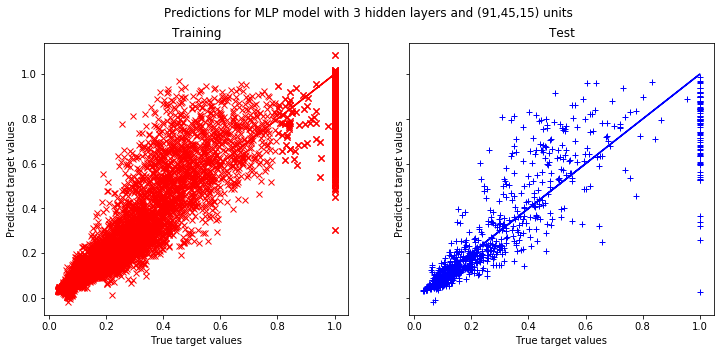

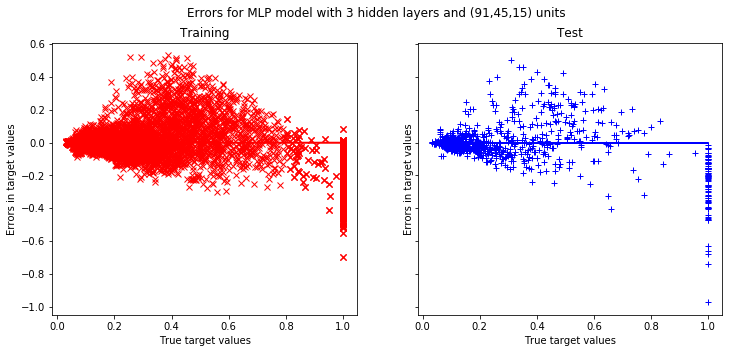

In [15]:
from sklearn.metrics import r2_score
X = featureVector(df_train['Latitude'].to_numpy(), df_train['Longitude'].to_numpy())
X_test = featureVector(df_test['Latitude'].to_numpy(), df_test['Longitude'].to_numpy())

y = np.array( df_train['score'].to_list() ).flatten()
y_test = np.array( df_test['score'].to_list() ).flatten()

bestMLPmodel = MLPmodel
print("=============================================================")

predictions = bestMLPmodel.predict(X)
predictions_test = bestMLPmodel.predict(X_test)
errors = predictions - y
errors_test = predictions_test - y_test
print("R2 score on full training set:", r2_score(y, predictions))
print("R2 score on test set:", r2_score(y_test, predictions_test))


f, axArr = plt.subplots(1,2, sharey='all',figsize=(12,5))
f.suptitle('Predictions for MLP model with 3 hidden layers and (91,45,15) units')
axArr[0].plot(y, predictions, 'rx')
axArr[0].plot(y,y,'r-'); axArr[0].set_title("Training")
axArr[0].set_xlabel("True target values"); axArr[0].set_ylabel("Predicted target values")

axArr[1].plot(y_test, predictions_test, 'b+')
axArr[1].plot(y_test,y_test,'b-'); axArr[1].set_title("Test")
axArr[1].set_xlabel("True target values"); axArr[1].set_ylabel("Predicted target values")
plt.show()

f, axArr = plt.subplots(1,2, sharey='all',figsize=(12,5))
f.suptitle('Errors for MLP model with 3 hidden layers and (91,45,15) units')
axArr[0].plot(y, errors, 'rx')
axArr[0].plot(y,0.*y,'r-'); axArr[0].set_title("Training")
axArr[0].set_xlabel("True target values"); axArr[0].set_ylabel("Errors in target values")

axArr[1].plot(y_test, errors_test, 'b+')
axArr[1].plot(y_test,0.*y_test,'b-'); axArr[1].set_title("Test")
axArr[1].set_xlabel("True target values"); axArr[1].set_ylabel("Errors in target values")
plt.show()





Looks like it should. Now, let's try predicting scores for a few locations outside the dataset.

In [16]:
# Suitability score for city center
print("Suitability score for city center:", MLPmodel.predict(featureVector(latCC, lngCC)) )

# For a point far away from the city...
latTest = 17.0; lngTest = 78.3
print("Suitability score for some location outside the city, ({},{}):{}".format(latTest,lngTest, MLPmodel.predict(featureVector(latTest,lngTest))  ))
latTest = 16.8; lngTest = 78.8
print("Suitability score for some location outside the city, ({},{}):{}".format(latTest,lngTest, MLPmodel.predict(featureVector(latTest,lngTest))  ))
latTest = 17.7; lngTest = 78.6
print("Suitability score for some location outside the city, ({},{}):{}".format(latTest,lngTest, MLPmodel.predict(featureVector(latTest,lngTest))  ))
      
      

Suitability score for city center: [0.31469405]
Suitability score for some location outside the city, (17.0,78.3):[0.38900017]
Suitability score for some location outside the city, (16.8,78.8):[0.17845923]
Suitability score for some location outside the city, (17.7,78.6):[0.27671736]


Oops. That doesn't look right. Or, these points outside the city are outside the scope of the model. After all, when we trained the model, we exclusively used points inside the city. Let's look at locations inside the city. We'll use the test set, and color code locations by __predicted__ suitability score. Blue for low scores, and red for high scores.

In [17]:
def clamp(x): 
  return max(0, min(x, 255))

def rgb2hex(r,g,b):
    return "#{0:02x}{1:02x}{2:02x}".format(clamp(r), clamp(g), clamp(b))

def blueRed(x):
    x = min(x, 1.)
    if x <= 0.5:
        r = int(512*x)
        b = 256
        g = int(512*x)
    else :
        r = 256
        b = int((1.-x)*512)
        g = int((1.-x)*512)
    return rgb2hex(r,g,b)

# Plot first 100 locations in dataset
map_tmp = folium.Map(
    location=[lat_CC, lng_CC], zoom_start=11)



for ind in range(len(df_test)):
    folium.CircleMarker(
        [df_test.iloc[ind,1], df_test.iloc[ind,2]],
        radius=3,
        fill=True,
        fill_color=blueRed(predictions_test[ind]),
        color = blueRed(predictions_test[ind]),
        fill_opacity=0.7).add_to(map_tmp)

print("Colormap: blue for S=0, red for S= 1")    
map_tmp

Colormap: blue for S=0, red for S= 1


Looks about right. Although, there are a few red points at the edges of the city. There are a many many more blue ones. I'll just try one feature vector, one with all distances being very large. Let's see what its score will be. 

In [18]:
testFeatVec = np.tile( np.linspace(25.,30.,num=10),9   ) # Distances going from 25km to 30km, 10 points, repeated 9 times

In [19]:
MLPmodel.predict(testFeatVec.reshape((1,-1))) 


array([0.2994191])

A suitability score of 0.3 for a location far from any venue. Clearly, this is a shortcoming of the model. It does not work for locations that are very far from the city. 

Let's define a single function to take us from location to suitability score.

In [20]:
def getScore(latArr, lngArr):
    X = featureVector(latArr, lngArr)
    y = MLPmodel.predict(X)
    if latArr.size == 1:
        return y[0] #If input is a scalar, return scalar
    else :
        return y # If input is an array or list, return numpy array

# Gradient descent

We can now produce a suitability score for any location in the city. We now need some algorithm that takes this function and finds locations that optimize suitability scores. Gradient descent happens to be one such algorithm. There are lots of others. Since we operate in 2d space (latitude and logitude are the only variables), even brute force search is possible. We'll stick to gradient descent though. Scipy has a lot of algorithms based on gradient descent. 

Actually, let's put gradient descent aside for a while and see how hard it is to brute force our way through. We'll find an optimal location for the sports center near the city center. We'll look at a 2km box around the city center.

In [21]:
from scipy.optimize import brute
from scipy import optimize

lat_min = latCC - 1.*360./circEarth  # 1km to the south
lat_max = latCC + 1.*360./circEarth # 1km to the north
lng_min = lngCC - 1.*360./circLatCity # 1km to the west
lng_max = lngCC + 1.*360./circLatCity # 1km to the east

# Step size for latitude and longitude; We'll use 0.25 km 
lat_step = 0.25*360./circEarth
lng_step = 0.25*360./circLatCity 

def minScoreFun(loc):
    assert loc.shape == (2,)
    return -1.*getScore(loc[0],loc[1])

rranges = ((lat_min, lat_max) , (lng_min, lng_max) )
res_brute = brute(minScoreFun, rranges, 
                  full_output=True, finish=None)

In [22]:
print("Optimal location is ({},{}) with score {}".format(*res_brute[0], -res_brute[1]))
print(lat_min, lat_max, lng_min, lng_max)

Optimal location is (17.414961598533313,78.48173817319295) with score 0.9006799787233841
17.406440372132952 17.424429627867045 78.46486924728892 78.48372275271107


In [23]:
showNearbyVenues('banks', res_brute[0][0], res_brute[0][1], useNames=False,allVenues=True)

Suitability scores for all of the locations used in brute search:

In [24]:
np.round(-res_brute[-1], 2)

array([[0.51, 0.49, 0.49, 0.5 , 0.54, 0.59, 0.61, 0.57, 0.56, 0.53, 0.55,
        0.53, 0.48, 0.45, 0.44, 0.5 , 0.56, 0.55, 0.56, 0.6 ],
       [0.47, 0.49, 0.5 , 0.5 , 0.53, 0.57, 0.58, 0.55, 0.52, 0.5 , 0.5 ,
        0.49, 0.47, 0.47, 0.5 , 0.54, 0.59, 0.59, 0.6 , 0.62],
       [0.46, 0.5 , 0.5 , 0.5 , 0.5 , 0.55, 0.55, 0.52, 0.49, 0.48, 0.48,
        0.47, 0.49, 0.53, 0.57, 0.58, 0.62, 0.63, 0.64, 0.68],
       [0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.53, 0.51, 0.48, 0.48, 0.46,
        0.48, 0.52, 0.55, 0.58, 0.59, 0.62, 0.66, 0.7 , 0.73],
       [0.51, 0.51, 0.51, 0.48, 0.47, 0.48, 0.49, 0.48, 0.42, 0.43, 0.42,
        0.46, 0.5 , 0.53, 0.55, 0.6 , 0.66, 0.74, 0.76, 0.78],
       [0.51, 0.54, 0.53, 0.48, 0.43, 0.43, 0.43, 0.41, 0.38, 0.4 , 0.41,
        0.43, 0.47, 0.5 , 0.56, 0.65, 0.73, 0.78, 0.81, 0.84],
       [0.52, 0.51, 0.49, 0.44, 0.4 , 0.39, 0.38, 0.36, 0.36, 0.37, 0.37,
        0.4 , 0.44, 0.53, 0.62, 0.7 , 0.77, 0.81, 0.84, 0.86],
       [0.5 , 0.48, 0.44, 0.4 , 0.38, 0.3

Brute force isn't that bad. It takes a few seconds, but it gets there. Later, we can increase step size to reduce cost if needed.

# Initialization

We will pick a few hundred random points in the city. Run brute force search for 2km boxes around each of these points. Save all of the optimal locations.

We could insted comb through the entire city. This would produce a lot of points to comb through, but at least we'd be thorough. I won't do that though. Because it will want to produce a global maximum. There isn't a lot we can do with a single maximu. I'd prefer to have a lot of local maxima. After all, 
1. The model isn't perfect, so the global maximum shouldn't be completely trusted.
2. We will later filter out locations close to existing sports facilities. So we need a lot of candidates.
3. There may be lots of restrictions on certain locations with regards to building sports facilities. Unavailable or expensive real estate, zoning laws, access to transport and parking, etc...

So, random points about the city. We don't want uniform points though. It makes more sense for sports facilities to be more profitable closer to the city center. Let's settle for middle ground. A few hundred uniformly distributed points, and an extra couple hundred normally distributed. For the normal distribution, we'll use the city center as the mean, and 2km as the standard deviation. 

In [25]:
# Define boundaries for the city, (lat0, long0) at south-west, (lat1, long1) north-east    
lat0 = 17.2
lng0 = 78.15
lat1 = 17.6
lng1 = 78.7

n_uniform = 800 # Number of locations 

# Random locations, uniformaly distributed
loc_min = [lat0, lng0]
loc_max = [lat1, lng1]
np.random.seed(5)   
q1 = np.random.uniform(low=loc_min, high=loc_max, size=(n_uniform,2))

n_normal = 200

std_lat = 2.*360./circEarth 
std_lng = 2.*360./circLatCity

q2 = np.random.randn(n_normal,2)
q2[:,0] = std_lat * q2[:,0] + latCC
q2[:,1] = std_lng * q2[:,1] + lngCC
# Drop q2 entries that are outside the city
q2 = q2[q2[:,0] >= lat_min]
q2 = q2[q2[:,0] <= lat_max]
q2 = q2[q2[:,1] >= lng_min]
q2 = q2[q2[:,1] <= lng_max]


q = np.concatenate((q1,q2), axis=0)

np.random.shuffle(q)

In [26]:
np.amax(q[:,0]), np.amin(q[:,0]),np.amax(q[:,1]), np.amin(q[:,1]), q.shape

(17.599945847146323,
 17.20015315774699,
 78.69918367199456,
 78.15060051016553,
 (821, 2))

We have locations. Now we find local maxima. 

In [27]:
from scipy.optimize import brute
from scipy import optimize
from tqdm import tqdm

def minScoreFun(loc):
    assert loc.shape == (2,)
    return -1.*getScore(loc[0],loc[1])

def findLocalMaximum(loc, box_size, box_step ):
    lat = loc[0]; lng = loc[1]
    lat_min = lat - (box_size/2.)*360./circEarth  # 2km to the south
    lat_max = lat + (box_size/2.)*360./circEarth # 2km to the north
    lng_min = lng - box_size/2.*360./circLatCity # 2km to the west
    lng_max = lng + box_size/2.*360./circLatCity # 2km to the east

    # Step size for latitude and longitude; We'll use 0.25 km 
    lat_step = box_step*360./circEarth
    lng_step = box_step*360./circLatCity 
    
    rranges = (slice(lat_min, lat_max, lat_step) , slice(lng_min, lng_max, lng_step) )
    res_brute = brute(minScoreFun, rranges, 
                  full_output=True,finish=None)
    
    return res_brute[0], -res_brute[1]

def findAllMaxima(locArr, box_size, box_step):
    optimalLocations = np.zeros(locArr.shape)
    optimalScores = np.zeros(locArr.shape[0])
    
    for ind in tqdm(range(locArr.shape[0]) ):
        optLoc, optScore = findLocalMaximum(locArr[ind], box_size, box_step)
        optimalLocations[ind] = optLoc
        optimalScores[ind] = optScore
    
    return optimalLocations, optimalScores


# Filtering

We will ignore locations with low suitability scores. And locations close to existing sports facilities. 

Before we get to that, let's find optimal locations within 3km boxes of the above random points.

In [28]:
optLocs, optScores = findAllMaxima(q, 3., 0.25)

100%|██████████| 821/821 [50:14<00:00,  3.02s/it] 


In [29]:
optScores

array([0.45323762, 0.90370321, 0.96985665, 0.20660414, 0.15692711,
       0.85937835, 0.80987243, 0.19797712, 0.32728214, 0.94581056,
       1.06136552, 0.2089654 , 0.69909623, 0.185974  , 1.04059836,
       0.74513126, 0.3014299 , 0.14309068, 0.09941764, 0.42133228,
       0.99044388, 0.60417619, 0.12421801, 0.91762223, 0.31987006,
       0.11477071, 0.93602013, 0.38221608, 1.02475265, 0.21117324,
       0.90054255, 0.96276602, 0.89900092, 0.40107992, 1.02291381,
       0.71309789, 0.15456746, 0.31295697, 0.79552487, 0.85576628,
       0.69468448, 0.19257946, 0.07769444, 0.35944217, 0.16713308,
       0.88899692, 0.0826292 , 0.71377976, 0.5091399 , 0.09666917,
       0.12075974, 0.79490073, 0.0893531 , 0.35208731, 0.23137117,
       0.31686422, 0.5802122 , 1.01748125, 0.58167367, 0.79579547,
       0.87996073, 0.06016318, 0.58758931, 0.1173985 , 0.18208626,
       0.99657899, 0.83879305, 0.24180456, 0.76466533, 0.8797219 ,
       1.05771113, 0.91250396, 0.21764186, 0.05935329, 1.05734

I'll keep only those locations that have a score greater than 0.7. Just because.

In [30]:
maskArr = optScores >= 0.7

optLocs = optLocs[maskArr]
optScores = optScores[maskArr]

In [31]:
optScores

array([0.90370321, 0.96985665, 0.85937835, 0.80987243, 0.94581056,
       1.06136552, 1.04059836, 0.74513126, 0.99044388, 0.91762223,
       0.93602013, 1.02475265, 0.90054255, 0.96276602, 0.89900092,
       1.02291381, 0.71309789, 0.79552487, 0.85576628, 0.88899692,
       0.71377976, 0.79490073, 1.01748125, 0.79579547, 0.87996073,
       0.99657899, 0.83879305, 0.76466533, 0.8797219 , 1.05771113,
       0.91250396, 1.05734685, 0.74692073, 0.96607565, 0.84422375,
       0.89325785, 0.93238106, 1.03178407, 0.75733838, 1.00902867,
       0.92385062, 0.94998083, 0.74559827, 0.88362222, 1.02257078,
       0.79837712, 0.82691202, 0.78654201, 1.01336492, 0.73367412,
       0.71735106, 0.93271584, 0.93991927, 0.90100031, 0.81963708,
       0.72119489, 0.94478038, 0.77373694, 0.85325   , 0.79510214,
       0.75200399, 0.93323196, 0.92294099, 0.95160695, 0.96590663,
       0.92016457, 0.79188996, 0.98456109, 0.74291067, 1.03941766,
       0.70046015, 0.91097953, 1.02674159, 0.85867294, 0.88429

I wanted to drop locations that are too close to existing sports facilities. Then I realized, it's not easy to figure out how close is too close. Some locations could have greater appetite for such facilities than others. So, I'll instead rank these locations by distance to sports facilities instead of completely dropping them. 

In [32]:
distSports = np.array( [ closestVenueModel['sports'].kneighbors([[loc[0],loc[1]]])[0][0,0] for loc in optLocs ] )
distSports

array([0.1269157 , 0.55362857, 0.45548883, 0.1673809 , 0.64832707,
       0.25599717, 0.2392009 , 0.17784956, 0.81257883, 0.14415892,
       0.22361371, 0.26555892, 0.35495514, 0.58178433, 0.00825776,
       0.37535073, 0.15679895, 0.17284275, 0.5633864 , 0.11891635,
       0.42714311, 0.18073317, 0.60833212, 0.14612094, 0.05912741,
       0.13087082, 0.1263129 , 0.53675246, 0.26938407, 0.22665113,
       0.19666988, 0.28960403, 0.54841205, 0.61160653, 0.34644577,
       0.68220461, 0.91211563, 0.47123606, 0.27273703, 0.15159562,
       0.29790486, 0.41345401, 0.48395165, 0.18258185, 0.18913613,
       0.7606043 , 0.14243222, 0.10979605, 0.30045687, 0.2610927 ,
       1.57662543, 0.52106692, 0.08033742, 0.11812442, 0.16736289,
       0.19421695, 0.29580195, 1.23575428, 0.20774894, 0.67845658,
       0.2274996 , 0.40073401, 0.25177469, 0.28096505, 0.61330242,
       0.33334096, 0.46178139, 0.26497944, 0.38813837, 0.3577366 ,
       0.26837031, 0.41995648, 0.56349004, 0.41005662, 0.24165

Now, sort locations by distances. 

In [33]:
sortInd = np.argsort(distSports)

# Sort in descending order
sortInd = sortInd[::-1]

In [34]:
sortedLocations = optLocs[sortInd]
sortedScores = optScores[sortInd]
sortedDistances = distSports[sortInd]

In [35]:
# Assign a rank to the sorted locations
rankArr = np.arange(1, sortedLocations.size+1)

In [36]:
sortedDistances

array([1.71345888, 1.64074657, 1.57662543, 1.47228339, 1.23575428,
       1.07057221, 1.05412534, 1.03402338, 0.94963726, 0.9363665 ,
       0.93146123, 0.91211563, 0.86629739, 0.86268599, 0.86204763,
       0.85297751, 0.83263362, 0.83095519, 0.81257883, 0.81069697,
       0.7987717 , 0.79863639, 0.79706035, 0.7955139 , 0.78679243,
       0.78329998, 0.77475788, 0.7606043 , 0.74541766, 0.73738454,
       0.73162183, 0.72604241, 0.72111648, 0.71958406, 0.71349247,
       0.71344167, 0.71277965, 0.70599528, 0.70316272, 0.69027278,
       0.68470571, 0.68220461, 0.67845658, 0.67629049, 0.65099002,
       0.64832707, 0.64566236, 0.62799009, 0.6268421 , 0.6217398 ,
       0.61861117, 0.61401535, 0.61374201, 0.61330242, 0.61160653,
       0.60833212, 0.60695618, 0.6029706 , 0.60188146, 0.59040537,
       0.58882767, 0.58871372, 0.58178433, 0.57170418, 0.56997565,
       0.5646189 , 0.56349004, 0.5633864 , 0.5619556 , 0.56114669,
       0.55858608, 0.55411471, 0.55396666, 0.55362857, 0.54841

# Final candidates

The locations with scores >= 0.7 are all sorted now. Let's show them on a map. 

In [37]:
minDist = np.amin(sortedDistances)
maxDist = np.amax(sortedDistances)
normalizeDist = lambda x: (x-minDist)/(maxDist-minDist)
def clamp(x): 
  return max(0, min(x, 255))

def rgb2hex(r,g,b):
    return "#{0:02x}{1:02x}{2:02x}".format(clamp(r), clamp(g), clamp(b))

def blueRed(x):
    x = min(x, 1.)
    if x <= 0.5:
        r = int(512*x)
        b = 256
        g = int(512*x)
    else :
        r = 256
        b = int((1.-x)*512)
        g = int((1.-x)*512)
    return rgb2hex(r,g,b)

# Plot first 100 locations in dataset
map_tmp = folium.Map(
    location=[lat_CC, lng_CC], zoom_start=11)



for ind in range(len(sortedLocations)):
    folium.CircleMarker(
        [sortedLocations[ind,0], sortedLocations[ind,1]],
        radius=3,
        fill=True,
        fill_color=blueRed(normalizeDist(sortedDistances[ind]) ),
        color = blueRed(normalizeDist(sortedDistances[ind])),
        fill_opacity=0.7).add_to(map_tmp)

print("Colormap: blue for locations closest to existing sports, red for farthest")    
map_tmp

Colormap: blue for locations closest to existing sports, red for farthest


In [38]:
print("Ten Locations farthest from existing facilities, their suitability score, and distance to closest sports venue:")
print("Latitude,  Longitude,  Score,  Dist_sports")

for ind in range(10):
    print("{:8.5f},  {:9.5f},  {:5.3f}, {:5.3f}".format(*sortedLocations[ind], sortedScores[ind], sortedDistances[ind]))

    
print();print()
print("=================================================================================================")
print("Ten Locations with largest scores, their suitability score, and distance to closest sports venue:")
print("Latitude,  Longitude,  Score,  Dist_sports")
sortInd_1 = np.argsort(sortedScores)[::-1]
sortedLocations_1 = sortedLocations[sortInd_1]
sortedScores_1 = sortedScores[sortInd_1]
sortedDistances_1 = sortedDistances[sortInd_1]
for ind in range(10):
    print("{:8.5f},  {:9.5f},  {:5.3f}, {:5.3f}".format(*sortedLocations_1[ind], sortedScores_1[ind], sortedDistances_1[ind]))
    

Ten Locations farthest from existing facilities, their suitability score, and distance to closest sports venue:
Latitude,  Longitude,  Score,  Dist_sports
17.36875,   78.44637,  0.822, 1.713
17.50392,   78.28929,  0.742, 1.641
17.50452,   78.28927,  0.717, 1.577
17.36855,   78.44410,  0.866, 1.472
17.32952,   78.29803,  0.774, 1.236
17.33192,   78.60972,  0.797, 1.071
17.33148,   78.60939,  0.786, 1.054
17.33420,   78.58860,  0.831, 1.034
17.50702,   78.41582,  0.892, 0.950
17.33377,   78.58774,  0.823, 0.936


Ten Locations with largest scores, their suitability score, and distance to closest sports venue:
Latitude,  Longitude,  Score,  Dist_sports
17.49856,   78.14140,  1.140, 0.497
17.35050,   78.39044,  1.122, 0.507
17.35051,   78.39026,  1.120, 0.526
17.35036,   78.38994,  1.096, 0.561
17.57517,   78.55680,  1.074, 0.251
17.57512,   78.55638,  1.070, 0.271
17.42683,   78.48830,  1.061, 0.256
17.42689,   78.48789,  1.058, 0.227
17.53130,   78.48780,  1.057, 0.290
17.47757,   78.320

In [43]:
# Top twenty suitable locations that are farthest from existing sports facilities

map_tmp = folium.Map(
    location=[lat_CC, lng_CC], zoom_start=12)



for ind in range(20):
    label = folium.Popup("score:{:.2f}, dist:{:.1f}km".format(
        sortedScores[ind], sortedDistances[ind]), parse_html=True)
    folium.CircleMarker(
        [sortedLocations[ind,0], sortedLocations[ind,1]],
        radius=3,
        fill=True,
        popup=label,
        fill_color='red',
        color = 'red',
        fill_opacity=0.7).add_to(map_tmp)

print("Twenty suitable locations that are farthest from existing sports facilities")
map_tmp

Twenty suitable locations that are farthest from existing sports facilities


Some suitability scores are greater than 1 because the MLP model has an output layer that doesn't use an activation function. This output layer just scales input from previous hidden layer.

__We have identified a handful of locations that are about a kilometer away from the nearest sports facility. With scores close to 1. That's not bad. And this ends the present exercise.__

# Summary

We used a nearest neighbor models for each venue category to calculate distances to 10 nearest venues for any specified location. These distances serve as input to the MLP model built in the previous notebook. For any specified location, we can use these distances and the MLP model to calculate the suitability score. 

I was planning on using gradient descent to find local maxima for suitability scores, but a brute force search isn't all that expensive. We used the brute force search to find local maxima for lots of random initial locations in the city. We dropped locations where the suitability score was less than 0.7. For the rest, we ranked them by distance to closest sports facility and plotted them on a map. Finally, we printed the ten optimal locations, by distance to nearest sports facility and by optimal score. 